# 验证1-具有神经网络思维的Logistic回归
--------
## 介绍

在本练习中，我们将搭建一个简单的神经网络（逻辑回归）并用于“识别猫”。

在开始练习前，需要**下载如下的文件进行数据上传**：

- train_catvnoncat.h5 -存储训练集数据（图像数据和标签）
- test_catvnoncat.h5  -存储测试集数据

在整个练习中，涉及如下的**必做作业**：

| 作业 | 分值 |
|--|--|
|[构建Sigmoid函数](#1)| 5分|
|[实现前向和后向传播的成本函数及其梯度](#2)|30分|
|[实现优化函数](#3)|20分|
|[实现预测函数](#4)|20分|
|[构建完整模型并训练](#5)|15分|


## 1 数据预处理
### 1.1 数据加载和查看
在开始之前，我们有需要引入的库：

- numpy ：是用Python进行科学计算的基本软件包。
- h5py：是与H5文件中存储的数据集进行交互的常用软件包。
- matplotlib：是一个著名的库，用于在Python中绘制图表。

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

接下来，需要运行load_dataset函数来读取数据文件中所存储的数据，并返回：

- train_set_x_orig ：保存的是训练集里面的图像数据(209张64x64的图像)；
- train_set_y_orig ：保存的是训练集的图像对应的分类值，其中0表示不是猫，1表示是猫。
- test_set_x_orig ：保存的是测试集里面的图像数据(50张64x64的图像)；
- test_set_y_orig ： 保存的是测试集的图像对应的分类值。
- classes ： 保存的是以字节类型保存的两个字符串数据，数据为：[b’non-cat’ b’cat’]。

现在我们就要把这些数据加载到主程序里面：

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

我们可以看一下加载的文件里面的图片都是些什么样子的以及存储的分类值。可以看到，当我们改变index值时，会出现不同索引值的图片，且train_set_y的值代表了该图像是否为一只猫。

train_set_y=1
y=[1], it's a cat' picture


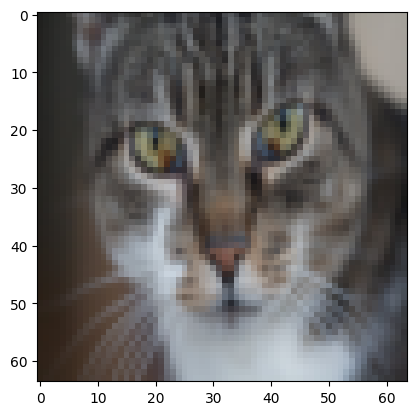

In [3]:
index = 56
plt.imshow(train_set_x_orig[index])
print("train_set_y=" + str(train_set_y[0][index]))
print("y=" + str(train_set_y[:, index]) + ", it's a " + classes[np.squeeze(train_set_y[:, index])].decode(
        "utf-8") + "' picture")

train_set_y=0
y=[0], it's a non-cat' picture


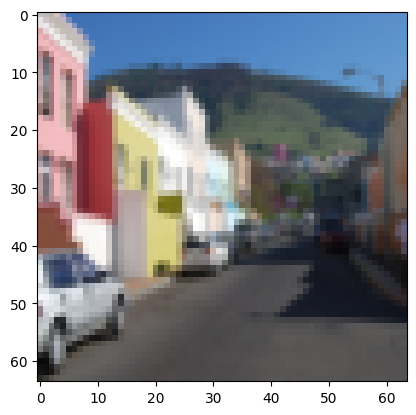

In [4]:
index = 1
plt.imshow(train_set_x_orig[index])
print("train_set_y=" + str(train_set_y[0][index]))
print("y=" + str(train_set_y[:, index]) + ", it's a " + classes[np.squeeze(train_set_y[:, index])].decode(
        "utf-8") + "' picture")

### 1.2 数据变换

接下来看一看我们加载的数据的具体信息，首先介绍三个变量的含义：
- m_train ：训练集里图片的数量。
- m_test ：测试集里图片的数量。
- num_px ： 训练、测试集里面的图片的宽度和高度（均为64x64）。

train_set_x_orig 是一个维度为(m_​​train，num_px，num_px，3）的数组。

In [5]:
m_train = train_set_y.shape[1]  #训练集里图片的数量。
m_test = test_set_y.shape[1]  #测试集里图片的数量。
num_px = train_set_x_orig.shape[1]  #训练、测试集里面的图片的宽度和高度（均为64x64）。

#现在看一看我们加载的东西的具体情况
print("训练集的数量: m_train = " + str(m_train))
print("测试集的数量 : m_test = " + str(m_test))
print("每张图片的宽/高 : num_px = " + str(num_px))
print("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print("训练集_标签的维数 : " + str(train_set_y.shape))
print("测试集_图片的维数: " + str(test_set_x_orig.shape))
print("测试集_标签的维数: " + str(test_set_y.shape))


训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)


为了方便，我们要把维度为`(64,64,3)`的numpy数组重新构造为`(64*64*3,1)`的数组，要乘以3的原因是每张图片是由`64x64`像素构成的，而每个像素点由（R，G，B）三原色构成的，所以要乘以3。

在此之后，我们的训练和测试数据集是一个numpy数组，**每列代表一个平坦的图像**，应该有m_train和m_test列。

当你想将形状（a，b，c，d）的矩阵X平铺成形状（b * c * d，a）的矩阵X_flatten时，可以使用以下代码：


In [16]:
#X_flatten = X.reshape(X.shape [0]，-1).T ＃X.T是X的转置
#将训练集的维度降低并转置。
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


这一段意思是指把数组变为209行的矩阵（因为训练集里有209张图片）我们可以用-1使得程序算出来是12288列，我再最后用一个T表示转置，这就变成了12288行，209列。

测试集的操作也一样。

然后我们看看降维之后的情况是怎么样的：

In [17]:
print("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print("训练集_标签的维数 : " + str(train_set_y.shape))
print("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print("测试集_标签的维数 : " + str(test_set_y.shape))

训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


为了表示彩色图像，必须为每个像素指定红色，绿色和蓝色通道（RGB），因此像素值实际上是从0到255范围内的三个数字的向量。

机器学习中一个常见的预处理步骤是**对数据集进行居中和标准化**，这意味着可以减去每个示例中整个numpy数组的平均值，然后将每个示例除以整个numpy数组的标准偏差。

但对于图片数据集，它更简单，更方便，几乎可以将**数据集的每一行除以255**（像素通道的最大值），因为在RGB中不存在比255大的数据，所以我们可以放心的除以255，让标准化的数据位于[0,1]之间。

In [18]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## 2 神经网络的搭建
数据处理完毕后，我们需要开始搭建神经网络。
以下是数学表达式：

对于 $x(i)$:
$${{z}^{(i)}}={{w}^{T}}{{x}^{(i)}}+b$$
$$\hat{y}^{(i)}=a(i)=sigmoid(z(i))$$
$$L\left( \hat{y},y \right)=-y\log(\hat{y})-(1-y)\log (1-\hat{y})$$

然后通过对所有训练样例求和来计算成本:
$$J\left( w,b \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{L\left( {{{\hat{y}}}^{(i)}},{{y}^{(i)}} \right)}=\frac{1}{m}\sum\limits_{i=1}^{m}{\left( -{{y}^{(i)}}\log {{{\hat{y}}}^{(i)}}-(1-{{y}^{(i)}})\log (1-{{{\hat{y}}}^{(i)}}) \right)}$$

建立神经网络的主要步骤是： 
1. 定义模型结构（例如输入特征的数量） 
2. 初始化模型的参数 
3. 循环：

    1. 计算当前损失（正向传播）
    2. 计算当前梯度（反向传播）
    3. 更新参数（梯度下降）

### 2.1 Sigmoid函数<span id='1'></span>

现在构建sigmoid()，需要使用 $sigmoid(w ^ T x + b)$ 计算来做出预测。

其中，sigmoid代表一个常用的逻辑函数为S形函数（Sigmoid function），公式为：

$$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$$

接下来，你需要**编写代码实现Sigmoid函数**，编写后试着测试一些值，如果`x`的正值较大，则函数值应接近1；如果`x`的负值较大，则函数值应接近0。而对于`x`等于0时，则函数值为0.5。

In [19]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。
    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [20]:
#测试sigmoid()
print("====================测试sigmoid====================")
print("sigmoid(0) = " + str(sigmoid(0)))
print("sigmoid(9.2) = " + str(sigmoid(9.2)))

====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


### 2.2 初始化参数
接下来，在搭建神经网络之前，我们需要初始化参数w和b，将w初始化为指定维度的零向量，b初始化为0。

In [21]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。
        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）
        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape=(dim, 1))
    b = 0
    #使用断言来确保我要的数据是正确的
    assert (w.shape == (dim, 1))  #w的维度是(dim,1)
    assert (isinstance(b, float) or isinstance(b, int))  #b的类型是float或者是int

    return (w, b)

### 2.3 成本函数和梯度<span id='2'></span>
对参数进行初始化后，可以接着实现前向和后向传播的成本函数及其梯度，用于后续的参数学习，最小化成本。

接下来，你需要**实现propagate函数，该函数用于实现前向传播的成本计算和后向传播的梯度计算**。

**要点**：
- 参数列表和返回值需要与函数说明中相同，其中返回值dw,db需要以字典的形式进行返回；
- 在函数中需要实现正向传播计算成本和反向传播计算梯度。


In [23]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)
    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]

    #正向传播
    A = sigmoid(np.dot(w.T, X) + b)  #计算激活值。
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  #计算成本。

    #反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    #使用断言确保我的数据是正确的
    assert (dw.shape == w.shape)
    assert (db.dtype == float)
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    #创建一个字典，把dw和db保存起来。
    grads = {
            "dw": dw,
            "db": db
            }
    return grads, cost

In [26]:
#测试一下propagate
print("====================测试propagate====================")
#初始化一些参数
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1, 2], [3, 4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost = " + str(cost))

====================测试propagate====================
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### 2.4 优化函数<span id='3'></span>
接下来，你需要**定义optimize函数通过使用propagate函数计算成本和梯度来最小化成本，并学习最优参数w和b**。对于参数 $\theta$ ，更新规则是 $ \theta = \theta - \alpha \text{ } d\theta$，其中 $\alpha$ 是学习率。


**要点**：
- 参数列表和返回列表如函数说明中所示，注意返回值的数据类型；
- 我们需要写下两个步骤并遍历它们：
    1. 计算当前参数的成本和梯度，使用propagate（）。
    2. 使用w和b的梯度下降法则更新参数。

In [25]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    此函数通过运行梯度下降算法来优化w和b
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值
    返回：
        params  - 包含权重w和偏差b的`字典`
        grads  - 包含权重和偏差相对于成本函数的梯度的`字典`
        costs - 优化期间计算的所有成本`列表`，将用于绘制学习曲线。
    """

    costs = []

    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        #记录成本
        if i % 100 == 0:
            costs.append(cost)
        #打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i, cost))

    params = {
            "w": w,
            "b": b}
    grads = {
            "dw": dw,
            "db": db}
    return params, grads, costs

In [27]:
#测试optimize
print("====================测试optimize====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1, 2], [3, 4]]), np.array([[1, 0]])
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)
print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

====================测试optimize====================
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### 2.5 实现预测函数<span id='4'></span>
通过优化函数可以输出已学习的w和b的值，我们可以使用w和b来预测数据集X的标签。

接下来，你需要**实现预测函数predict（）**。

计算预测有两个步骤：
1. 计算$\bar{Y}=A=\sigma(w^TX+b)$
2. 将a的值变为0（如果激活值<= 0.5）或者为1（如果激活值> 0.5）

然后将预测值存储在向量Y_prediction中。



In [28]:
def predict(w, b, X):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据
    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）
    """

    m = X.shape[1]  #图片的数量
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    #计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    #使用断言
    assert (Y_prediction.shape == (1, m))

    return Y_prediction

In [29]:
#测试predict
print("====================测试predict====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1, 2], [3, 4]]), np.array([[1, 0]])
print("predictions = " + str(predict(w, b, X)))

====================测试predict====================
predictions = [[1. 1.]]


### 2.6 构建神经网络模型<span id='4'></span>

回顾搭建神经网络模型的步骤： 
1. 定义模型结构（例如输入特征的数量） 
2. 初始化模型的参数 
3. 循环：

    1. 计算当前损失（正向传播）
    2. 计算当前梯度（反向传播）
    3. 更新参数（梯度下降）
    
我们目前已经实现了参数的初始化、成本和梯度的计算、参数更新函数以及预测函数。接下来，你需要**搭建完整的神经网络模型，定义model()函数**。

**要点**：
- 参数列表和返回列表如函数说明所示；
- 需要分别计算训练集和测试集预测的准确率并输出。



In [30]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    #从字典“参数”中检索参数w和b
    w, b = parameters["w"], parameters["b"]

    #预测测试/训练集的例子
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    #打印训练后的准确性
    print("训练集准确性：", format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100), "%")
    print("测试集准确性：", format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100), "%")

    d = {
            "costs": costs,
            "Y_prediction_test": Y_prediction_test,
            "Y_prediciton_train": Y_prediction_train,
            "w": w,
            "b": b,
            "learning_rate": learning_rate,
            "num_iterations": num_iterations}
    return d

In [31]:
print("====================测试model====================")
#这里加载的是真实的数据，请参见上面的代码部分。
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

====================测试model====================
迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


## 3 模型结果分析
在上述的模型结果中，我们可以看到模型在训练集和测试集上的不同表现。当我们修改学习率和迭代次数时，准确率会有些许的变化。现在我们将模型训练过程中的成本优化过程可视化，直观的观察模型训练过程。


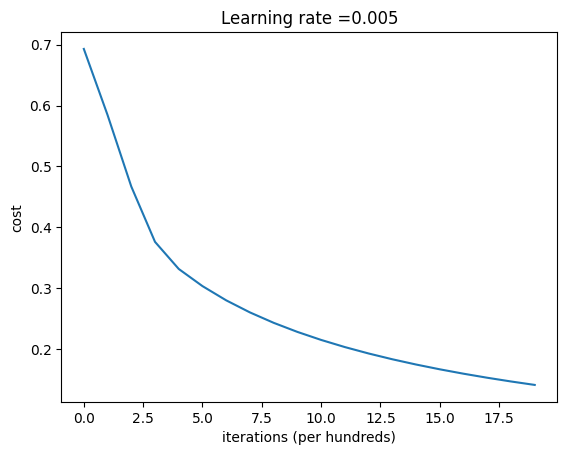

In [32]:
#绘制图
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()


可以看到在每次的迭代过程中，成本值都在降低，说明模型参数正在被学习。
### 3.1 学习率的选择

在模型参数中有一个“学习率”的概念，学习率决定了模型更新参数的速度，如果学习率设置的过高，模型可能会“超过”最小值，反之，则会造成过慢的收敛速度。
接下来，可以比较一下在你的模型上选用不同学习率时模型的变化。

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



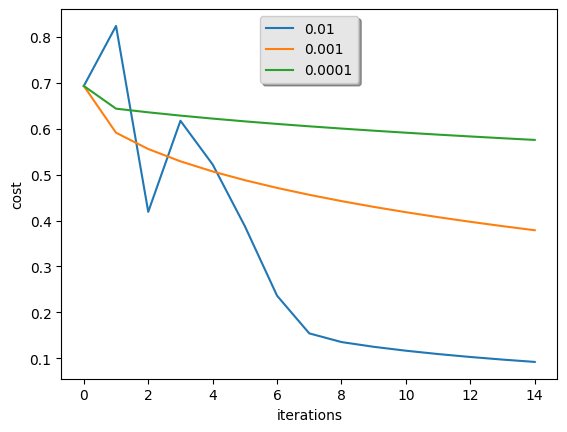

In [34]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=i,
                           print_cost=False)
    print('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()